In [1]:
import pandas as pd
import numpy as np
from dataset import dataset
import yaml
from torch import nn ,optim
import matplotlib.pyplot as plt
from glob import glob
import os

In [2]:
exp_subj_list = [(2,0),(2,1),(2,2),(2,3),(2,4),(2,5),(2,6),(2,7),(2,8),(2,9)]
#(exp__num, subj_num)

In [ ]:
name = 'model_upgrade_exp_2_left_final'

## pred list

In [ ]:
## All

pred_list = sorted(glob('results_G/prediction/exp_2_final_64step/*.csv'),key = lambda x:int(x.split('/')[-1].split('.')[0][4:]))

for subj,pred in enumerate(pred_list):
    print(pred.split('/')[-1])
    data = pd.read_csv(pred)
    data.plot(figsize=(15,5))
    plt.title(f'Subj_{subj}')
    #plt.savefig('./')
    plt.show()
    

In [ ]:
##left or right

pred_list = sorted(glob(f'results_G/prediction/{name}_64step/*.csv'),key = lambda x:int(x.split('/')[-1].split('.')[0][4:]))

for pred,tup in zip(pred_list,exp_subj_list):
    print(pred.split('/')[-1])
    data = pd.read_csv(pred)
    data.plot(figsize=(15,5))
    plt.title(f'exp_{tup[0]}_Subj_{tup[1]}')
    plt.savefig(f'./pred_exp_{tup[0]}_Subj_{tup[1]}')
    plt.show()
    

## loss list

In [ ]:
## All

losses = sorted(glob('./results_G/loss/exp_2_final/*.csv'))
for idx,loss in enumerate(losses):
    print(loss)
    df = pd.read_csv(loss)
    max_idx = df[df['valid_acc']==df['valid_acc'].max()].index
    df.plot(figsize=(15,5))
    plt.axvline(x=max_idx[-1],color='r',linestyle='--')
    plt.title('Subj{}'.format(idx))
    plt.savefig('./Subj{}.png'.format(idx))
    plt.show()

./results_G/loss/model_upgrade_exp_2_left_final/Subj0.csv


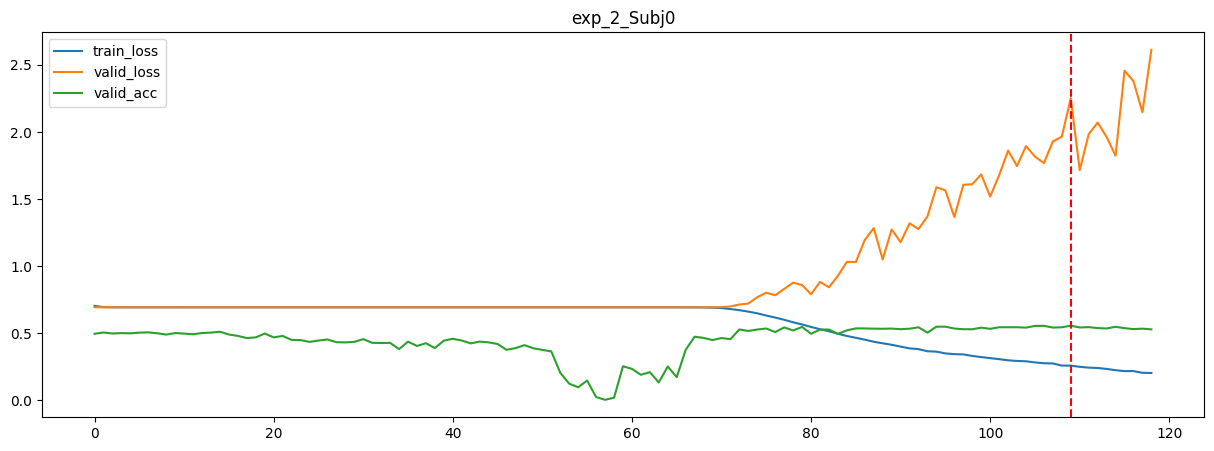

./results_G/loss/model_upgrade_exp_2_left_final/Subj1.csv


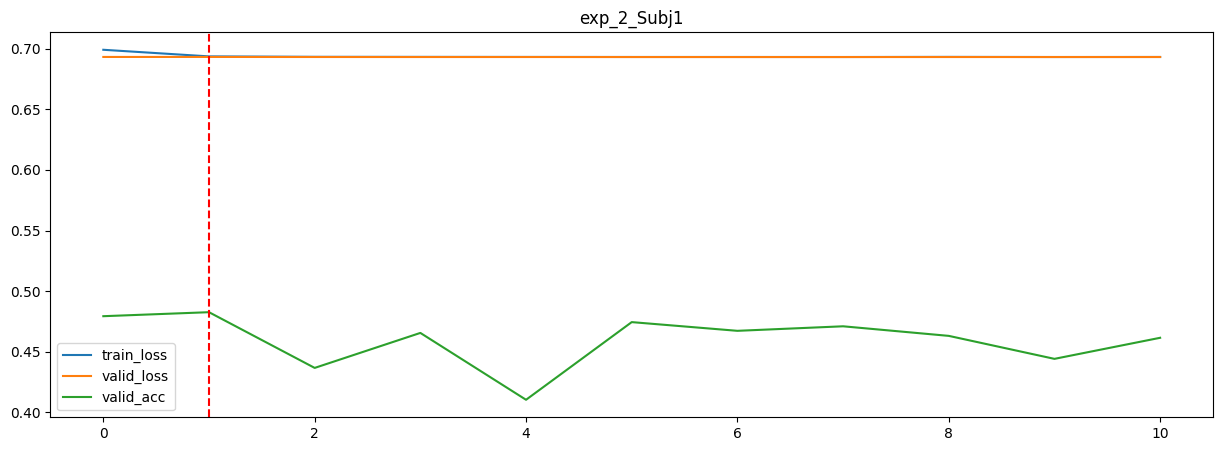

./results_G/loss/model_upgrade_exp_2_left_final/Subj2.csv


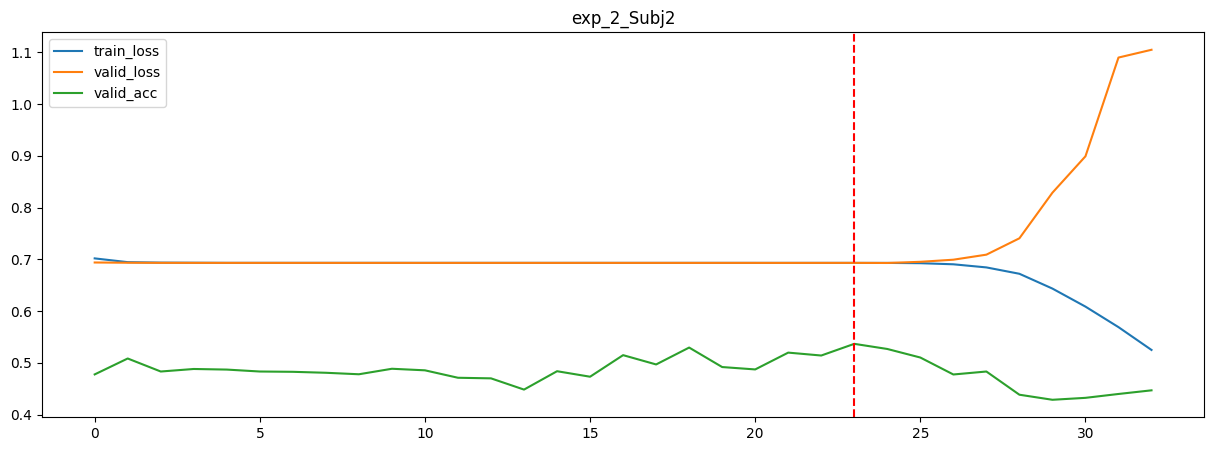

./results_G/loss/model_upgrade_exp_2_left_final/Subj3.csv


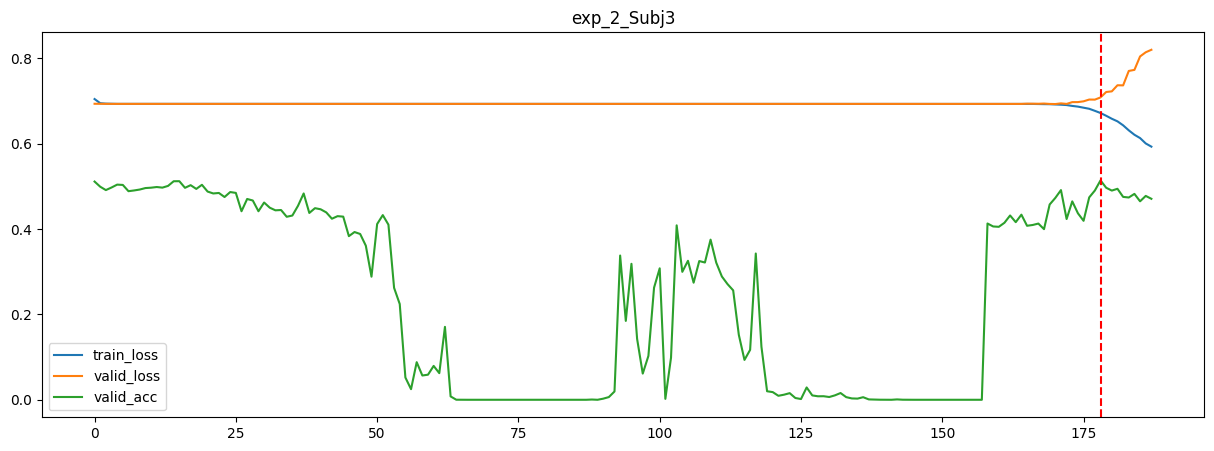

./results_G/loss/model_upgrade_exp_2_left_final/Subj4.csv


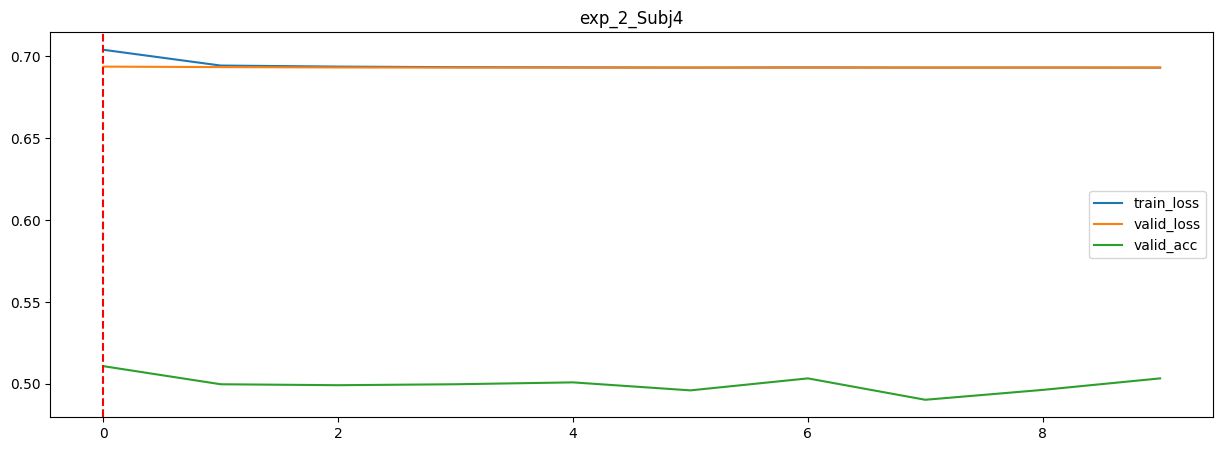

./results_G/loss/model_upgrade_exp_2_left_final/Subj5.csv


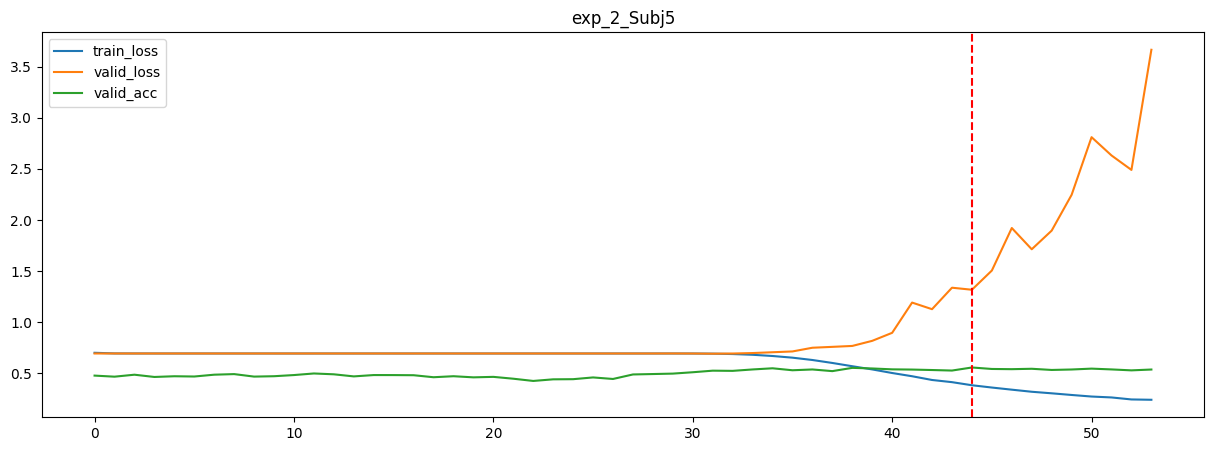

./results_G/loss/model_upgrade_exp_2_left_final/Subj6.csv


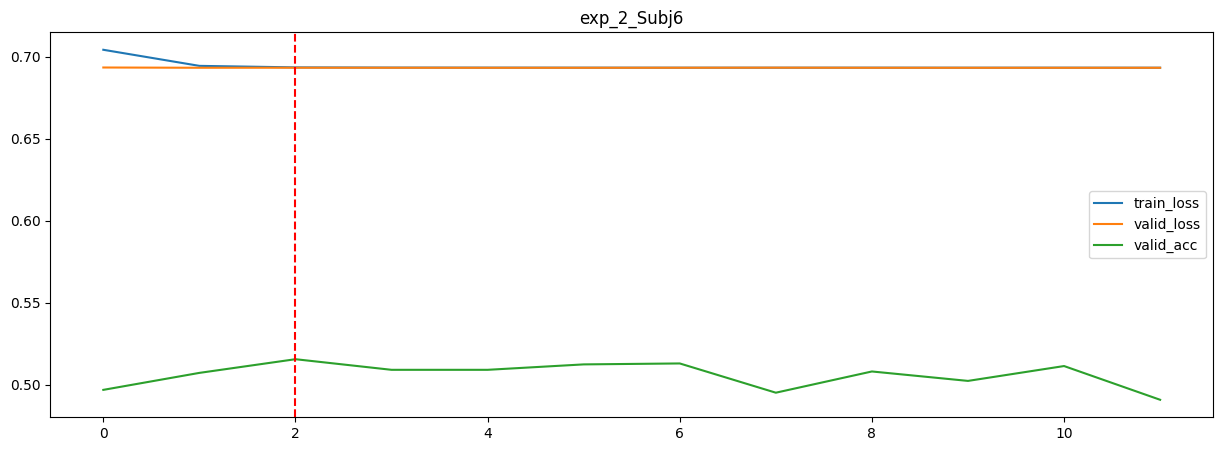

./results_G/loss/model_upgrade_exp_2_left_final/Subj7.csv


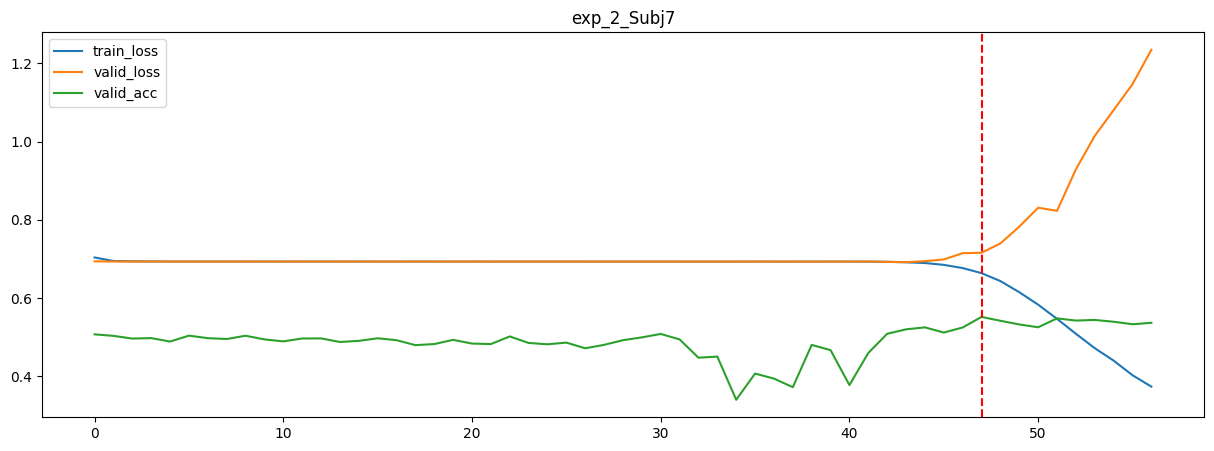

./results_G/loss/model_upgrade_exp_2_left_final/Subj8.csv


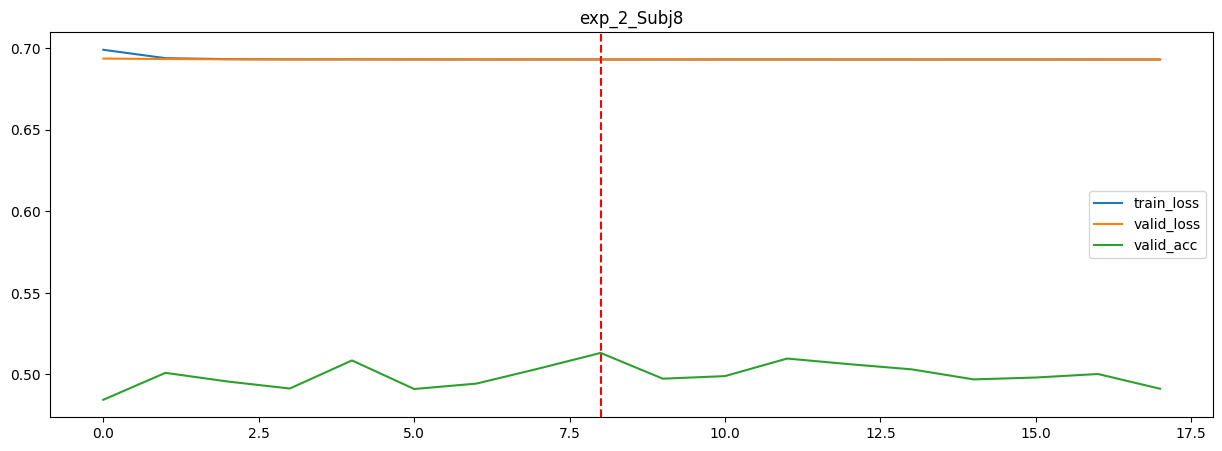

./results_G/loss/model_upgrade_exp_2_left_final/Subj9.csv


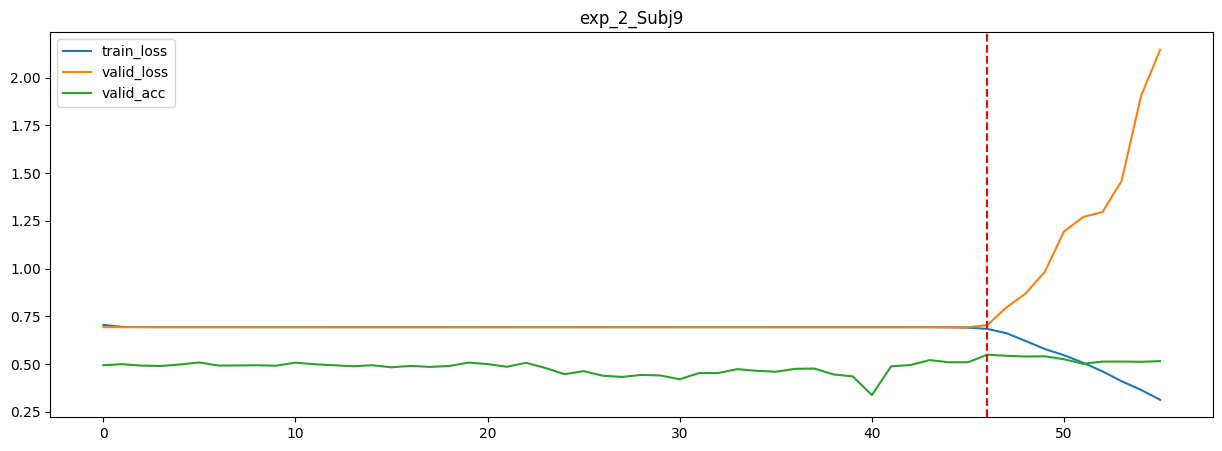

In [3]:
##left or right

losses = sorted(glob(f'./results_G/loss/{name}/*.csv'),key = lambda x:int(x.split('/')[-1].split('.')[0][4:]))
for loss,tup in zip(losses,exp_subj_list):
    print(loss)
    df = pd.read_csv(loss)
    max_idx = df[df['valid_acc']==df['valid_acc'].max()].index
    df.iloc[:max_idx[0]+10,:].plot(figsize=(15,5))
    plt.axvline(x=max_idx,color='r',linestyle='--')
    plt.title('exp_{}_Subj{}'.format(tup[0],tup[1]))
    plt.savefig('loss_exp_{}_Subj{}.png'.format(tup[0],tup[1]))
    plt.show()

## Train test

In [ ]:
# All
import torch
import numpy as np
import pandas as pd
import random
import yaml
import os
from glob import glob
import argparse
from models import models
import pickle
import warnings
import json


window_list = [60, 4, 8, 12, 16, 20]

columns = ["idx"] + ["window"+str(window_list[i//2])+"_binary" if i % 2 == 0 else "window"+str(window_list[i//2])+"_sum"
                     for i in range(len(window_list) * 2)]

result_df = pd.DataFrame(columns=columns)

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    np.random.default_rng(seed)
    random.seed(seed)

with open('./configs/model_upgrage_exp_01_left_final.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(config["seed"])

if isinstance(config['csv_folder'],list):
    path_list1 = sorted(glob(config["csv_folder"][0]))
    path_list2 = sorted(glob(config["csv_folder"][1]))
    path_list = path_list1 + path_list2
else:
    path_list = sorted(glob(config["csv_folder"]))
    
print(len(path_list))

for t, idx in enumerate(range(0,len(path_list),30)):
    true_pred_list = []
    false_pred_list = []
    
    true_input_list = []
    false_input_list = []
    
    temp = path_list.copy()
    del temp[idx:idx+30]
    
    for path in temp: #subj
        df = pd.read_csv(path)
        eeg = df.iloc[:, :60]
        attn = df["attn"]
        uattn = df["uattn"]

        eeg_numpy = eeg.to_numpy()
        attn_numpy = attn.to_numpy()
        uattn_numpy = uattn.to_numpy()

        eeg_data = []
        for i in range(0, eeg.shape[0] - config["temporal_size"] + 1, config["temporal_size"]):
            cut_eeg = eeg_numpy[i:i + config["temporal_size"]]
            eeg_data.append(cut_eeg)
        attn_data = []
        for i in range(0, len(attn) - config["temporal_size"] + 1, config["temporal_size"]):
            cut_attn = attn_numpy[i:i + config["temporal_size"]]
            attn_data.append(cut_attn)
        uattn_data = []
        for i in range(0, len(uattn) - config["temporal_size"] + 1, config["temporal_size"]):
            cut_uattn = uattn_numpy[i:i + config["temporal_size"]]
            uattn_data.append(cut_uattn)
            

        eeg_data = np.array(eeg_data) #batch,128,60
        attn_data = np.expand_dims(np.array(attn_data), 2)
        uattn_data = np.expand_dims(np.array(uattn_data), 2)
        

        # scaler_save_folder = os.path.join("./results_G/scaler", config["data_name"])
        # scaler_save_path = os.path.join(scaler_save_folder, "Subj{}.pickle".format(t))
        
        # with open(scaler_save_path, 'rb') as f:
        #     scaler = pickle.load(f)
        
        # eeg_data = scaler.transform(eeg_data.reshape(-1, 60))
        # eeg_data = eeg_data.reshape(-1,config["temporal_size"],60)
        
        true_inputs = np.concatenate([eeg_data, attn_data], axis=2)
        false_inputs = np.concatenate([eeg_data, uattn_data], axis=2)
        
        scaled_true_input = true_inputs.transpose((0, 2, 1))
        scaled_false_input = false_inputs.transpose((0, 2, 1))
        
        true_input_list.append(scaled_true_input)
        false_input_list.append(scaled_false_input)
        
    true_inputs_concat = np.concatenate(true_input_list, axis=0) 
    false_inputs_concat = np.concatenate(false_input_list, axis=0) 

    model = models.CNNSim()
    model_path = os.path.join("./results_G/saved_model", config["data_name"], "Subj{}.pt".format(t))
    #model_path = os.path.join("./results_G/saved_model", config["data_name"], "Subj{}.pt".format(t))
    print("Subj{}.pt model loaded".format(t))
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model = model.to(device)
    
    for c in range(true_inputs_concat.shape[0]):
        cut_true_inputs = true_inputs_concat[np.newaxis, c, ...]
        cut_false_inputs = false_inputs_concat[np.newaxis, c, ...]
        cut_true_inputs = torch.from_numpy(cut_true_inputs).to(device).float()
        cut_false_inputs = torch.from_numpy(cut_false_inputs).to(device).float()
        true_pred = model(cut_true_inputs)
        false_pred = model(cut_false_inputs)

        true_pred_list.append(true_pred.cpu().detach().numpy()[0][0])
        false_pred_list.append(false_pred.cpu().detach().numpy()[0][0])

    pred = pd.DataFrame({"True_pred": true_pred_list,
                        "False_pred": false_pred_list})
        
    pred.plot(figsize=(15,5))
    plt.title(f'Subj_{t}_train_plot')
    plt.show()
    
    row = ['Subj{}_train'.format(t)]
    for window_size in window_list:
        step = window_size // 2
        decision_count = 0
        binary_True = 0
        sum_True = 0
            
        for trial in range(0,len(pred),30): #trial마다 900개를 30개씩
            temp = pred[trial:trial+30]
            temp_len = len(temp)

            for idx in range(0, temp_len - step + 1):
                attn = temp["True_pred"][idx:idx + step]
                unattn = temp["False_pred"][idx:idx + step]

                result = attn > unattn
                if result.sum() > step // 2:
                    binary_True += 1

                if attn.sum() > unattn.sum():
                    sum_True += 1
                decision_count += 1
        row.extend([binary_True/decision_count, sum_True/decision_count])
    row_df = pd.DataFrame([row], columns=columns)
    result_df = pd.concat([result_df, row_df])


In [ ]:
#left or right

import torch
import numpy as np
import pandas as pd
import random
import yaml
import os
from glob import glob
import argparse
from models import models
import pickle
import warnings
import json
import matplotlib.pyplot as plt

window_list = [60, 4, 8, 12, 16, 20]

columns = ["idx"] + ["window"+str(window_list[i//2])+"_binary" if i % 2 == 0 else "window"+str(window_list[i//2])+"_sum"
                     for i in range(len(window_list) * 2)]

result_df = pd.DataFrame(columns=columns)

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    np.random.default_rng(seed)
    random.seed(seed)

with open('./configs/exp_01_right_final.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(config["seed"])

if isinstance(config['csv_folder'],list):
    path_list1 = sorted(glob(config["csv_folder"][0]))
    path_list2 = sorted(glob(config["csv_folder"][1]))
    path_list = path_list1 + path_list2
else:
    path_list = sorted(glob(config["csv_folder"]))
    
print(len(path_list))

for t, (idx,tup) in enumerate(zip(range(0,len(path_list),30),exp_subj_list)):
    true_pred_list = []
    false_pred_list = []
    
    true_input_list = []
    false_input_list = []
    
    temp = path_list.copy()
    del temp[idx:idx+30]
    
    for path in temp: #subj
        df = pd.read_csv(path)
        eeg = df.iloc[:, :60]
        attn = df["attn"]
        uattn = df["uattn"]

        eeg_numpy = eeg.to_numpy()
        attn_numpy = attn.to_numpy()
        uattn_numpy = uattn.to_numpy()

        eeg_data = []
        for i in range(0, eeg.shape[0] - config["temporal_size"] + 1, config["temporal_size"]):
            cut_eeg = eeg_numpy[i:i + config["temporal_size"]]
            eeg_data.append(cut_eeg)
        attn_data = []
        for i in range(0, len(attn) - config["temporal_size"] + 1, config["temporal_size"]):
            cut_attn = attn_numpy[i:i + config["temporal_size"]]
            attn_data.append(cut_attn)
        uattn_data = []
        for i in range(0, len(uattn) - config["temporal_size"] + 1, config["temporal_size"]):
            cut_uattn = uattn_numpy[i:i + config["temporal_size"]]
            uattn_data.append(cut_uattn)
            

        eeg_data = np.array(eeg_data) #batch,128,60
        attn_data = np.expand_dims(np.array(attn_data), 2)
        uattn_data = np.expand_dims(np.array(uattn_data), 2)
        

        # scaler_save_folder = os.path.join("./results_G/scaler", config["data_name"])
        # scaler_save_path = os.path.join(scaler_save_folder, "Subj{}.pickle".format(t))
        
        # with open(scaler_save_path, 'rb') as f:
        #     scaler = pickle.load(f)
        
        # eeg_data = scaler.transform(eeg_data.reshape(-1, 60))
        # eeg_data = eeg_data.reshape(-1,config["temporal_size"],60)
        
        true_inputs = np.concatenate([eeg_data, attn_data], axis=2)
        false_inputs = np.concatenate([eeg_data, uattn_data], axis=2)
        
        scaled_true_input = true_inputs.transpose((0, 2, 1))
        scaled_false_input = false_inputs.transpose((0, 2, 1))
        
        true_input_list.append(scaled_true_input)
        false_input_list.append(scaled_false_input)
        
    true_inputs_concat = np.concatenate(true_input_list, axis=0) 
    false_inputs_concat = np.concatenate(false_input_list, axis=0) 

    model = models.CNNSim()
    model_path = os.path.join("./results_G/saved_model", config["data_name"], "Subj{}.pt".format(t))
    #model_path = os.path.join("./results_G/saved_model", config["data_name"], "Subj{}.pt".format(t))
    print("Subj{}.pt model loaded".format(t))
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model = model.to(device)
    
    for c in range(true_inputs_concat.shape[0]):
        cut_true_inputs = true_inputs_concat[np.newaxis, c, ...]
        cut_false_inputs = false_inputs_concat[np.newaxis, c, ...]
        cut_true_inputs = torch.from_numpy(cut_true_inputs).to(device).float()
        cut_false_inputs = torch.from_numpy(cut_false_inputs).to(device).float()
        true_pred = model(cut_true_inputs)
        false_pred = model(cut_false_inputs)

        true_pred_list.append(true_pred.cpu().detach().numpy()[0][0])
        false_pred_list.append(false_pred.cpu().detach().numpy()[0][0])

    pred = pd.DataFrame({"True_pred": true_pred_list,
                        "False_pred": false_pred_list})
        
    pred.plot(figsize=(15,5))
    plt.title(f'exp_{tup[0]}_Subj_{tup[1]}_train_plot')
    plt.show()
    
    row = [f'exp_{tup[0]}_Subj{tup[1]}_train']
    for window_size in window_list:
        step = window_size // 2
        decision_count = 0
        binary_True = 0
        sum_True = 0
            
        for trial in range(0,len(pred),30): #trial마다 900개를 30개씩
            temp = pred[trial:trial+30]
            temp_len = len(temp)

            for idx in range(0, temp_len - step + 1):
                attn = temp["True_pred"][idx:idx + step]
                unattn = temp["False_pred"][idx:idx + step]

                result = attn > unattn
                if result.sum() > step // 2:
                    binary_True += 1

                if attn.sum() > unattn.sum():
                    sum_True += 1
                decision_count += 1
        row.extend([binary_True/decision_count, sum_True/decision_count])
    row_df = pd.DataFrame([row], columns=columns)
    result_df = pd.concat([result_df, row_df])


In [7]:
result_df = result_df.set_index("idx")
result_df *= 100
result_df

,window60_binary,window60_sum,window4_binary,window4_sum,window8_binary,window8_sum,window12_binary,window12_sum,window16_binary,window16_sum,window20_binary,window20_sum
idx,,,,,,,,,,,,
exp_0_Subj2_train,99.583333,100.000000,67.097701,89.152299,82.901235,94.737654,89.450000,97.466667,92.644928,98.586957,94.960317,98.869048
exp_0_Subj4_train,99.166667,99.166667,63.908046,87.571839,80.061728,93.472222,87.200000,96.083333,90.778986,97.300725,93.154762,97.916667
exp_0_Subj6_train,92.500000,98.333333,59.051724,81.422414,74.228395,87.978395,81.483333,90.683333,85.072464,92.500000,87.222222,93.948413
exp_0_Subj8_train,100.000000,100.000000,92.844828,99.037356,99.058642,99.907407,99.833333,100.000000,100.000000,100.000000,100.000000,100.000000
exp_1_Subj1_train,100.000000,100.000000,96.408046,99.827586,99.753086,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
exp_1_Subj3_train,100.000000,100.000000,85.071839,96.752874,94.845679,98.858025,97.716667,99.583333,98.894928,99.927536,99.464286,99.940476
exp_1_Subj4_train,100.000000,100.000000,96.666667,99.741379,99.521605,99.984568,99.850000,100.000000,99.909420,100.000000,99.920635,100.000000
exp_1_Subj6_train,100.000000,100.000000,94.698276,99.066092,99.305556,99.876543,99.866667,99.983333,100.000000,100.000000,100.000000,100.000000
exp_1_Subj8_train,100.000000,100.000000,93.563218,99.425287,99.012346,99.907407,99.700000,99.966667,99.891304,99.981884,100.000000,100.000000


In [10]:
df = pd.read_csv(f"./results_G/result_final_{name}.csv")
df = df.sort_values("idx")
df["idx"] = df["idx"].apply(lambda x: x.replace("_final_64step", ""))
df = df.set_index("idx")
df *= 100
df

,window60_binary,window60_sum,window4_binary,window4_sum,window8_binary,window8_sum,window12_binary,window12_sum,window16_binary,window16_sum,window20_binary,window20_sum
idx,,,,,,,,,,,,
Subj0,100.000000,100.000000,63.448276,86.091954,77.654321,91.111111,85.600000,95.333333,91.594203,96.666667,94.285714,97.142857
Subj1,93.333333,100.000000,49.425287,80.000000,66.296296,87.407407,74.666667,91.200000,80.724638,94.347826,84.920635,95.873016
Subj2,96.666667,96.666667,60.574713,84.827586,75.308642,88.888889,80.400000,91.200000,84.927536,92.318841,87.460317,93.809524
Subj3,96.666667,96.666667,60.344828,82.413793,75.555556,88.395062,82.133333,91.466667,86.666667,93.478261,89.682540,95.396825
Subj4,86.666667,83.333333,47.471264,69.080460,61.111111,72.098765,67.333333,73.333333,72.028986,74.492754,73.650794,75.714286
Subj5,76.666667,80.000000,41.379310,67.931034,57.777778,72.345679,62.800000,73.466667,65.652174,75.072464,65.238095,74.761905
Subj6,90.000000,90.000000,45.517241,68.160920,61.358025,74.444444,69.733333,78.800000,77.536232,80.724638,81.269841,81.904762
Subj7,83.333333,90.000000,46.091954,68.735632,61.111111,72.716049,69.200000,76.533333,72.608696,78.115942,74.761905,78.571429
Subj8,100.000000,96.666667,54.597701,78.965517,69.506173,84.444444,78.800000,85.733333,83.478261,88.695652,85.873016,90.952381


In [12]:
ids = ['exp_{}_Subj_{}'.format(i,j) for i,j in exp_subj_list]
    

df.index = ids
df

,window60_binary,window60_sum,window4_binary,window4_sum,window8_binary,window8_sum,window12_binary,window12_sum,window16_binary,window16_sum,window20_binary,window20_sum
exp_0_Subj_2,100.000000,100.000000,63.448276,86.091954,77.654321,91.111111,85.600000,95.333333,91.594203,96.666667,94.285714,97.142857
exp_0_Subj_4,93.333333,100.000000,49.425287,80.000000,66.296296,87.407407,74.666667,91.200000,80.724638,94.347826,84.920635,95.873016
exp_0_Subj_6,96.666667,96.666667,60.574713,84.827586,75.308642,88.888889,80.400000,91.200000,84.927536,92.318841,87.460317,93.809524
exp_0_Subj_8,96.666667,96.666667,60.344828,82.413793,75.555556,88.395062,82.133333,91.466667,86.666667,93.478261,89.682540,95.396825
exp_1_Subj_1,86.666667,83.333333,47.471264,69.080460,61.111111,72.098765,67.333333,73.333333,72.028986,74.492754,73.650794,75.714286
exp_1_Subj_3,76.666667,80.000000,41.379310,67.931034,57.777778,72.345679,62.800000,73.466667,65.652174,75.072464,65.238095,74.761905
exp_1_Subj_4,90.000000,90.000000,45.517241,68.160920,61.358025,74.444444,69.733333,78.800000,77.536232,80.724638,81.269841,81.904762
exp_1_Subj_6,83.333333,90.000000,46.091954,68.735632,61.111111,72.716049,69.200000,76.533333,72.608696,78.115942,74.761905,78.571429
exp_1_Subj_8,100.000000,96.666667,54.597701,78.965517,69.506173,84.444444,78.800000,85.733333,83.478261,88.695652,85.873016,90.952381


In [13]:
comp_df = pd.DataFrame({'window60_sum_valid':df['window60_sum'].values,'window60_sum_train':result_df['window60_sum'].values},index=df.index)
comp_df

,window60_sum_valid,window60_sum_train
exp_0_Subj_2,100.000000,100.000000
exp_0_Subj_4,100.000000,99.166667
exp_0_Subj_6,96.666667,98.333333
exp_0_Subj_8,96.666667,100.000000
exp_1_Subj_1,83.333333,100.000000
exp_1_Subj_3,80.000000,100.000000
exp_1_Subj_4,90.000000,100.000000
exp_1_Subj_6,90.000000,100.000000
exp_1_Subj_8,96.666667,100.000000


<Axes: >

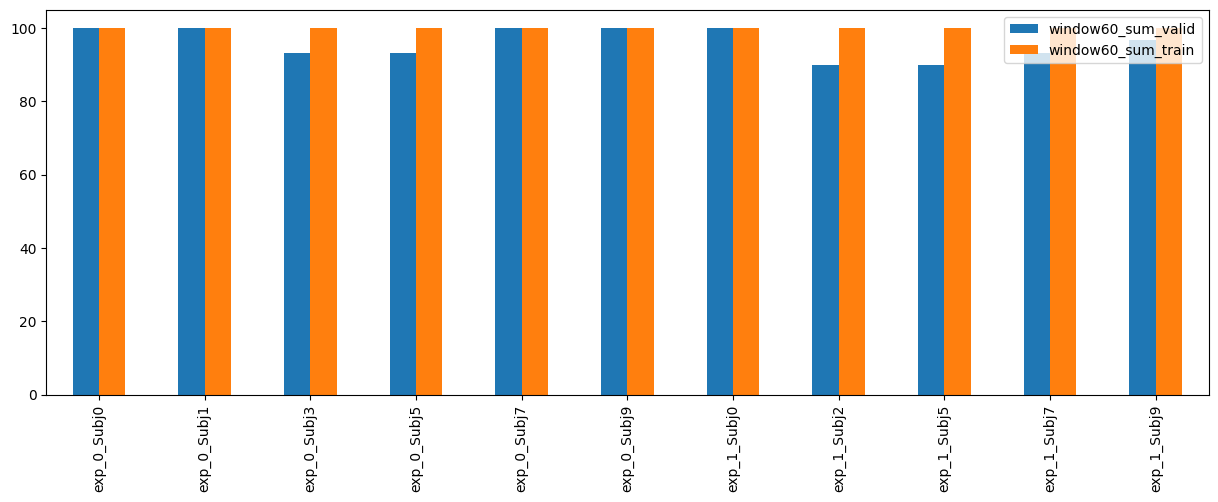

In [ ]:
comp_df.plot(kind='bar',figsize=(15,5))

## Left or Right

In [28]:
import numpy as np
import h5py
import pandas as pd

In [29]:
filepath = "./data/DATA(3conditions)_rev210330.mat"
matfile = h5py.File(filepath, 'r')

eeg_dat = matfile['DATA']['EEG']
subj_dat = matfile['DATA']['INDEX']
speech_env = matfile['DATA']['SPEECH']
exp_cond = matfile['DATA']['Label']

In [41]:
exp=0
subj=2

for exp in range(3):
    print(f'exp_{exp}')
    for subj in range(10):
        subj_ds = matfile[subj_dat[exp][0]]
        print(f'subj_{subj}:',np.unique(np.array(subj_ds[subj_ds['left_is_1'][subj][0]])))
        #print(f'subj_{subj}:',np.array(subj_ds[subj_ds['left_is_1'][subj][0]])[0])
        #np.array(subj_ds[subj_ds['left_is_1'][subj][0]])
        
    print('\n')

exp_0
subj_0: [1.]
subj_1: [1.]
subj_2: [0.]
subj_3: [1.]
subj_4: [0.]
subj_5: [1.]
subj_6: [0.]
subj_7: [1.]
subj_8: [0.]
subj_9: [1.]


exp_1
subj_0: [1.]
subj_1: [0.]
subj_2: [1.]
subj_3: [0.]
subj_4: [0.]
subj_5: [1.]
subj_6: [0.]
subj_7: [1.]
subj_8: [0.]
subj_9: [1.]


exp_2
subj_0: [0. 1.]
subj_1: [0. 1.]
subj_2: [0. 1.]
subj_3: [0. 1.]
subj_4: [0. 1.]
subj_5: [0. 1.]
subj_6: [0. 1.]
subj_7: [0. 1.]
subj_8: [0. 1.]
subj_9: [0. 1.]




In [30]:
exp_2_dict = {}

exp=2
print(f'exp_{exp}')
for subj in range(10):
    subj_ds = matfile[subj_dat[exp][0]]
    exp_2_dict[f'subj_{subj}'] = np.array(subj_ds[subj_ds['left_is_1'][subj][0]])[0].astype(int).tolist()

exp_2


In [31]:
for key in exp_2_dict:
    print(key,np.where(np.array(exp_2_dict[key])==1))

subj_0 (array([ 0,  2,  4,  8,  9, 10, 12, 13, 14, 19, 21, 23, 26, 27, 29]),)
subj_1 (array([ 0,  2,  4,  8,  9, 10, 12, 13, 14, 19, 21, 23, 26, 27, 29]),)
subj_2 (array([ 1,  3,  4,  6,  9, 10, 12, 13, 16, 18, 19, 21, 25, 26, 29]),)
subj_3 (array([ 1,  4,  5,  6,  9, 10, 12, 14, 17, 18, 19, 21, 25, 27, 29]),)
subj_4 (array([ 1,  4,  5,  6,  9, 10, 12, 14, 17, 18, 19, 21, 25, 27, 29]),)
subj_5 (array([ 1,  4,  5,  6,  9, 10, 12, 14, 17, 18, 19, 21, 25, 27, 29]),)
subj_6 (array([ 0,  1,  2,  8,  9, 10, 12, 13, 16, 20, 21, 23, 24, 28, 29]),)
subj_7 (array([ 1,  4,  5,  6,  7,  9, 14, 15, 16, 18, 19, 22, 24, 26, 28]),)
subj_8 (array([ 1,  4,  5,  6,  7,  9, 14, 15, 16, 18, 19, 22, 24, 26, 28]),)
subj_9 (array([ 1,  2,  5,  6,  7,  8, 12, 15, 17, 20, 21, 22, 25, 27, 29]),)


In [50]:
final_path_list = []
for key in exp_2_dict:
    if 'left' in config['data_name']:
        ids = np.where(np.array(exp_2_dict[key])==1)
    else:
        ids = np.where(np.array(exp_2_dict[key])==0)
        
    temp = [i for i in path_list if key in i.split('/')[-1]]
    temp = [i for i in temp if int(i.split('/')[-1].split('_')[-1][:-4]) in ids[0]]
    final_path_list.extend(temp)
path_list = final_path_list

In [57]:
import pickle

with open('./exp_2_dict.pkl','wb') as f:
    pickle.dump(exp_2_dict,f)